In [1]:
import os
import numpy as np
from keras.preprocessing import image
from keras.layers import Input, Conv2D, Conv2DTranspose, Activation, Flatten, Dense, merge, Lambda, Reshape
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
import keras
from keras.models import Model
from keras.layers.advanced_activations import LeakyReLU
import keras.backend as K


Using TensorFlow backend.


In [2]:
data_images = '/dataset/photo/'
test_images = '/test/test_photo/'

images = [data_images+i for i in os.listdir(data_images)]
test_images = [test_images+i for i in os.listdir(test_images)]
test_sketches = []
sketches = []

for img in images:
    str = img.split('.')[0] + '-sz1.jpg'
    str = str.replace('photo', 'sketch')
    str = str.replace('m', 'm2')
    str = str.replace('f', 'f2')
    sketches.append(str)
    
for img in test_images:
    str = img.split('.')[0] + '-sz1.jpg'
    str = str.replace('test_photo', 'test_sketch')
    test_sketches.append(str)
    
sketches = sketches + test_sketches
photos = images + test_images




In [3]:
def create_train_sets(sketches_addr, photos_addr):
    X_train = []
    Y_train= []
    
    for i in xrange(len(sketches_addr)):
        path = sketches_addr[i]
        temp_img = image.load_img(path, target_size=(128,128,3))
        temp_img = image.img_to_array(temp_img)
        X_train.append(temp_img)
        
    
    for i in xrange(len(photos_addr)):
        path = photos_addr[i]
        temp_img = image.load_img(path, target_size=(128,128,3))
        temp_img = image.img_to_array(temp_img)
        Y_train.append(temp_img)
    
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    
    X_train = X_train.astype('float32')
    Y_train = Y_train.astype('float32')
    
    X_train = X_train/255
    Y_train = Y_train/255
    X_train = X_train * 2 -1
    Y_train = Y_train *2 -1
    
    return X_train, Y_train
        
    
        

In [4]:
X_train = []
Y_train = []
X_train, Y_train = create_train_sets(sketches, photos)

In [5]:
def generator():
    input_shape=((128,128,3))
    img_rows,img_cols=128,128

    inputs = Input((img_rows,img_cols,3))
    conv1 = Conv2D(32, (7,7), strides=(1,1) ,padding="same")(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation("relu")(conv1)
    
    conv2 = Conv2D(64, (3,3), strides=(2,2),padding="same" )(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation("relu")(conv2)
    
    conv3 = Conv2D(128, (3,3), strides=(2,2),padding="same")(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation("relu")(conv3)
    
    b1 = Conv2D(128, (3,3), padding="same")(conv3)
    b1 = BatchNormalization()(b1)
    b1 = Activation("relu")(b1)
    b2 = Conv2D(128, (3,3), padding="same")(b1)
    b2 = BatchNormalization()(b2)
    b2 = Activation("relu")(b2)
    block1 = keras.layers.add([b1,b2])
    
    b1 = Conv2D(128, (3,3), padding="same")(block1)
    b1 = BatchNormalization()(b1)
    b1 = Activation("relu")(b1)
    b2 = Conv2D(128, (3,3), padding="same")(b1)
    b2 = BatchNormalization()(b2)
    b2 = Activation("relu")(b2)
    block2 = keras.layers.add([b1,b2])
    
    b1= Conv2D(128, (3,3), padding="same")(block2)
    b1 = BatchNormalization()(b1)
    b1 = Activation("relu")(b1)
    b2 = Conv2D(128, (3,3), padding="same")(b1)
    b2 = BatchNormalization()(b2)
    b2 = Activation("relu")(b2)
    block3 = keras.layers.add([b1,b2])
    
    b1 = Conv2D(128, (3,3), padding="same")(block3)
    b1 = BatchNormalization()(b1)
    b1 = Activation("relu")(b1)
    b2 = Conv2D(128, (3,3), padding="same")(b1)
    b2 = BatchNormalization()(b2)
    b2 = Activation("relu")(b2)
    block4 = keras.layers.add([b1,b2])
    
    b1 = Conv2D(128, (3,3), padding="same")(block4)
    b1 = BatchNormalization()(b1)
    b1 = Activation("relu")(b1)
    b2 = Conv2D(128, (3,3), padding="same")(b1)
    b2 = BatchNormalization()(b2)
    b2 = Activation("relu")(b2)
    block5 = keras.layers.add([b1,b2])
    
    b1 = Conv2D(128, (3,3), padding="same")(block5)
    b1 = BatchNormalization()(b1)
    b1 = Activation("relu")(b1)
    b2 = Conv2D(128, (3,3), padding="same")(b1)
    b2 = BatchNormalization()(b2)
    b2 = Activation("relu")(b2)
    block6 = keras.layers.add([b1,b2])

    u1 = Conv2DTranspose(64, (3,3), strides=(2, 2),padding="same")(block6)
    u1 = BatchNormalization()(u1)
    u1 = Activation("relu")(u1)
    
    u2 = Conv2DTranspose(32, (3,3), strides=(2, 2),padding="same")(u1)
    u2 = BatchNormalization()(u2)
    u2 = Activation("relu")(u2)
    
    conv4 = Conv2D(3, (3,3), strides=(1,1),padding="same" )(u2)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation("relu")(conv4)
    
    model = Model(inputs=[inputs], outputs=[conv4])
    return model

    
    

In [6]:
def minb_disc(x):
    diffs = K.expand_dims(x, 3) - K.expand_dims(K.permute_dimensions(x, [1, 2, 0]), 0)
    abs_diffs = K.sum(K.abs(diffs), 2)
    x = K.sum(K.exp(-abs_diffs), 2)

    return x


def lambda_output(input_shape):
    return input_shape[:2]


def discriminator(img_dim, nb_patch):
    
    list_input = [Input(img_dim,name="disc_input_%s" % i) for i in range(16)]
    nb_filters = 64
    nb_conv = int(np.floor(np.log(img_dim[1])/np.log(2)))
    list_filters = [nb_filters*min(8,(2**i)) for i in range(nb_conv)]
    
    x_input = Input(img_dim, name="discriminator_input")
    
    x = Conv2D(list_filters[0], (3,3), strides=(2,2), name="disc_conv2d_1", padding='same')(x_input)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    for i,f in enumerate(list_filters[1:]):
        name = "disc_conv2d_%s" %(i+2)
        x = Conv2D(f, (3,3), strides=(2,2), name=name,padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)
        
    x_flat = Flatten()(x)
    x = Dense(2, activation='softmax', name="disc_dense")(x_flat)
    
    PatchGAN = Model(input=[x_input], output=[x,x_flat], name='PatchGAN')
    print("PatchGAN summary")
    print PatchGAN.summary()
    
    x = [PatchGAN(patch)[0] for patch in list_input]
    x_mbd = [PatchGAN(patch)[1] for patch in list_input]
    
    x = merge(x, mode="concat", name="merge_feat")
    x_mbd = merge(x_mbd, mode="concat", name="merge_feat_mdb")
    
    M = Dense(500, bias=False, activation=None)
    MBD = Lambda(minb_disc, output_shape=lambda_output)
    
    x_mbd = M(x_mbd)
    x_mbd = Reshape((100,5))(x_mbd)
    x_mbd = MBD(x_mbd)
    x = merge([x,x_mbd], mode='concat')
    
    x_out = Dense(2, activation='softmax', name="disc_output")(x)
    
    discriminator_model= Model(input=list_input, output=[x_out], name="DCGAN_discriminator")
    
    return discriminator_model



In [7]:
def DCGAN(generator, discriminator_model, img_dim, patch_size):
    gen_input = Input(shape=img_dim, name="DCGAN_input")
    generated_image = generator(gen_input)
    
    h, w = img_dim[:-1]
    ph, pw = patch_size
    
    list_row_idx = [(i*ph, (i+1)*pw) for i in range(h/ph)]
    list_col_idx = [(i*pw, (i+1)*pw) for i in range(w/pw)]
    
    list_gen_patch =[]
    
    for row_idx in list_row_idx:
        for col_idx in list_col_idx:
            x_patch = Lambda(lambda z: z[:, row_idx[0]:row_idx[1], col_idx[0]:col_idx[1], :])(generated_image)
            list_gen_patch.append(x_patch)
    
    DCGAN_output = discriminator_model(list_gen_patch)
    DCGAN = Model(input=[gen_input], output=[generated_image, DCGAN_output], name="DCGAN")
    return DCGAN

In [8]:
def discriminator_loss(y_true,y_pred):
    BATCH_SIZE=10
    return K.mean(K.binary_crossentropy(K.flatten(y_pred), K.concatenate([K.ones_like(K.flatten(y_pred[:BATCH_SIZE])),K.zeros_like(K.flatten(y_pred[:BATCH_SIZE])) ]) ), axis=-1)

def mean_squared_error(y_true, y_pred):
    return 10*K.mean(K.square(y_pred - y_true), axis=-1)

def discriminator_on_generator_loss(y_true,y_pred):
    BATCH_SIZE=10
    return K.mean(K.binary_crossentropy(K.flatten(y_pred), K.ones_like(K.flatten(y_pred))), axis=-1)

def l1_loss(y_true, y_pred):
    return K.sum(K.abs(y_pred - y_true), axis=-1)

In [9]:
optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

img_dim_disc = (32,32,3)
nb_patch = 16
img_dim = (128,128,3)
patch_size=(32,32)

generator_model = generator()
discriminator_model = discriminator(img_dim_disc,nb_patch)
generator_model.compile(loss='mae', optimizer=optimizer)
discriminator_model.trainable = False

DCGAN_model = DCGAN(generator_model,discriminator_model,img_dim,patch_size)
loss = [l1_loss, 'binary_crossentropy']
loss_weights = [1E1, 1]
DCGAN_model.compile(loss=loss, loss_weights=loss_weights, optimizer=optimizer)
discriminator_model.trainable = True
discriminator_model.compile(loss='binary_crossentropy', optimizer=optimizer)


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:35: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., name="PatchGAN", inputs=[<tf.Tenso...)`


PatchGAN summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa (None, 32, 32, 3)         0         
_________________________________________________________________
disc_conv2d_1 (Conv2D)       (None, 16, 16, 64)        1792      
_________________________________________________________________
batch_normalization_19 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
disc_conv2d_2 (Conv2D)       (None, 8, 8, 128)         73856     
_________________________________________________________________
batch_normalization_20 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0   

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:42: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:43: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:45: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, activation=None, use_bias=False)`
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:51: UserWarning: The `merge` function is deprecated and will be removed after 08

In [10]:
def getPatch(X, patch_size):
    list_X = []
    list_row_idx = [(i * patch_size[0], (i + 1) * patch_size[0]) for i in range(X.shape[1] / patch_size[0])]
    list_col_idx = [(i * patch_size[1], (i + 1) * patch_size[1]) for i in range(X.shape[2] / patch_size[1])]

    for row_idx in list_row_idx:
        for col_idx in list_col_idx:
            list_X.append(X[:, row_idx[0]:row_idx[1], col_idx[0]:col_idx[1], :])

    

    return list_X

In [32]:
num_epochs = 30
batch_size = 32


for epoch in range(200):
    print "\nEpoch number : %d" %epoch
    
    '''if epoch<=3:
        temp_loss=g.fit(sketch_img,photo_img)'''
    for batch in range(X_train.shape[0]//batch_size):
        X = X_train[batch*batch_size:(batch+1)*(batch_size)]
        Y = Y_train[batch*batch_size:(batch+1)*(batch_size)]
        generated_images=generator_model.predict(X,verbose=0)
        #print generated_images.shape
        X_all = np.concatenate((Y,generated_images), axis=0)
        #y_disc = [1,0] * batch_size + [0,1] * batch_size
        y_disc = np.zeros((generated_images.shape[0], 2), dtype=np.uint8)
        y_disc[:, 0] = 1
        y_disc1 = np.zeros((generated_images.shape[0], 2), dtype=np.uint8)
        y_disc1[:,1] = 1
        
        y_disc = np.concatenate((y_disc1,y_disc),axis=0)
        
        X_disc = getPatch(X_all,patch_size)

        def scheduler(epoch):
            if epoch >= 100:
                decay=0.001
                LearningRate = LearningRate * 1/(1 + decay * epoch)
                model.lr.set_value(LearningRate)
                
            return model.lr.get_value()
        
        discriminator_model.trainable=True
        for i in range(1):
            d_loss=discriminator_model.train_on_batch(X_disc, y_disc)
        discriminator_model.trainable=False
        y_gen = np.zeros((generated_images.shape[0], 2), dtype=np.uint8)
        y_gen[:, 1] = 1
        for i in range(3):
            #label_y=discriminator_Y[:batch_size]
            g_loss = DCGAN_model.train_on_batch(X,[Y,y_gen])
        
        
        discriminator_model.trainable = True
        print("\tbatch %d dcgan : %f,%f  disciminator: %f "  %(batch, g_loss[0], g_loss[1], d_loss))
        


Epoch number : 0
	batch 0 dcgan : 4.273184,0.425302  disciminator: 0.002637 
	batch 1 dcgan : 4.326791,0.430429  disciminator: 0.002755 
	batch 2 dcgan : 4.345398,0.431881  disciminator: 0.002159 
	batch 3 dcgan : 4.311033,0.428088  disciminator: 0.003767 
	batch 4 dcgan : 4.815179,0.478016  disciminator: 0.001240 

Epoch number : 1
	batch 0 dcgan : 4.217555,0.419574  disciminator: 0.002128 
	batch 1 dcgan : 4.251809,0.423179  disciminator: 0.002269 
	batch 2 dcgan : 4.357362,0.433309  disciminator: 0.001368 
	batch 3 dcgan : 4.247812,0.422226  disciminator: 0.001378 
	batch 4 dcgan : 4.677729,0.464093  disciminator: 0.000994 

Epoch number : 2
	batch 0 dcgan : 4.170798,0.415044  disciminator: 0.001603 
	batch 1 dcgan : 4.242548,0.422410  disciminator: 0.002247 
	batch 2 dcgan : 4.308681,0.428681  disciminator: 0.001378 
	batch 3 dcgan : 4.197202,0.417479  disciminator: 0.001370 
	batch 4 dcgan : 4.669958,0.463760  disciminator: 0.000882 

Epoch number : 3
	batch 0 dcgan : 4.145616,0.

	batch 4 dcgan : 4.372438,0.435432  disciminator: 0.000190 

Epoch number : 26
	batch 0 dcgan : 3.874678,0.386201  disciminator: 0.000427 
	batch 1 dcgan : 4.072126,0.406013  disciminator: 0.000688 
	batch 2 dcgan : 4.082860,0.407173  disciminator: 0.000255 
	batch 3 dcgan : 3.937837,0.392565  disciminator: 0.000278 
	batch 4 dcgan : 4.419952,0.440444  disciminator: 0.000212 

Epoch number : 27
	batch 0 dcgan : 3.833853,0.382313  disciminator: 0.000466 
	batch 1 dcgan : 4.081298,0.407123  disciminator: 0.000802 
	batch 2 dcgan : 4.049530,0.403674  disciminator: 0.000231 
	batch 3 dcgan : 3.909839,0.389818  disciminator: 0.000206 
	batch 4 dcgan : 4.377646,0.436288  disciminator: 0.000201 

Epoch number : 28
	batch 0 dcgan : 3.839612,0.382920  disciminator: 0.000375 
	batch 1 dcgan : 4.042692,0.403327  disciminator: 0.000635 
	batch 2 dcgan : 4.090520,0.407863  disciminator: 0.000170 
	batch 3 dcgan : 3.903488,0.389200  disciminator: 0.000201 
	batch 4 dcgan : 4.386439,0.437301  discimi

	batch 3 dcgan : 3.859963,0.385049  disciminator: 0.000116 
	batch 4 dcgan : 4.346401,0.433302  disciminator: 0.000126 

Epoch number : 52
	batch 0 dcgan : 3.813174,0.380545  disciminator: 0.000226 
	batch 1 dcgan : 4.000954,0.399361  disciminator: 0.000394 
	batch 2 dcgan : 3.996973,0.398700  disciminator: 0.000098 
	batch 3 dcgan : 3.808089,0.379891  disciminator: 0.000116 


KeyboardInterrupt: 

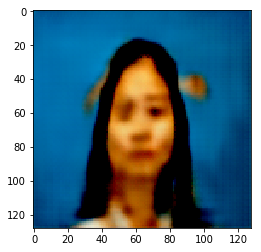

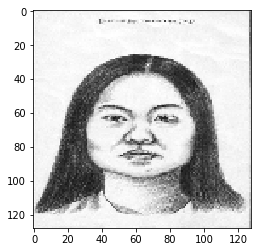

###########################################


In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
def imshow(x ,gray=False):
    plt.imshow(x)
    plt.show()

temp_img=image.load_img("test.jpg",target_size=(128,128,3))
temp_img1=image.img_to_array(temp_img)
temp_img1 = temp_img1.astype('float32')
temp_img1=temp_img1/255
temp_img1 = temp_img1*2 -1
a=np.zeros((1,128,128,3))
a[0]=temp_img1.astype(np.float32)
result= generator_model.predict(a)
result1 = result.astype('float32')

result1 = (result + 1)/2
result1*=255
imshow(result[0])
imshow(temp_img)

print "###########################################"

temp_img=image.load_img("test1.jpg",target_size=(128,128,3))
temp_img1=image.img_to_array(temp_img)
temp_img1 = temp_img1.astype('float32')
temp_img1=temp_img1/255
temp_img1 = temp_img1*2 -1
a=np.zeros((1,128,128,3))
a[0]=temp_img1.astype(np.float32)
result= generator_model.predict(a)
result1 = result.astype('float32')

result1 = (result + 1)/2
result1*=255
imshow(result[0])
imshow(temp_img)

print "###########################################"

temp_img=image.load_img("test2.jpg",target_size=(128,128,3))
temp_img1=image.img_to_array(temp_img)
temp_img1 = temp_img1.astype('float32')
temp_img1=temp_img1/255
temp_img1 = temp_img1*2 -1
a=np.zeros((1,128,128,3))
a[0]=temp_img1.astype(np.float32)
result= generator_model.predict(a)
result1 = result.astype('float32')

result1 = (result + 1)/2
result1*=255
imshow(result[0])
imshow(temp_img)

print "###########################################"

temp_img=image.load_img("test3.jpg",target_size=(128,128,3))
temp_img1=image.img_to_array(temp_img)
temp_img1 = temp_img1.astype('float32')
temp_img1=temp_img1/255
temp_img1 = temp_img1*2 -1
a=np.zeros((1,128,128,3))
a[0]=temp_img1.astype(np.float32)
result= generator_model.predict(a)
result1 = result.astype('float32')

result1 = (result + 1)/2
result1*=255
imshow(result[0])
imshow(temp_img)

print "###########################################"